## **Importing libraries and datasets**

In [1]:
!conda install -y numpy pandas matplotlib
!conda install -y scikit-learn scikit-learn-intelex

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\py\envs\7105

  added / updated specs:
    - matplotlib
    - numpy
    - pandas


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2021.5.3~ --> pkgs/main::ca-certificates-2021.5.25-haa95532_1
  certifi            conda-forge::certifi-2021.5.30-py38ha~ --> pkgs/main::certifi-2021.5.30-py38haa95532_0
  openssl            conda-forge::openssl-1.1.1k-h8ffe710_0 --> pkgs/main::openssl-1.1.1k-h2bbff1b_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: D:\py\envs\7105

  added / updated specs:
    - scikit-learn
    - scikit-learn-intelex


The following packages will be downloaded:

    package                    |            build
    ---------------------------|------

In [2]:
!conda install -y xgboost seaborn
!conda install -y -c conda-forge imbalanced-learn

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\py\envs\7105

  added / updated specs:
    - imbalanced-learn


The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2021.5.25-~ --> conda-forge::ca-certificates-2021.5.30-h5b45459_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            pkgs/main::certifi-2021.5.30-py38haa9~ --> conda-forge::certifi-2021.5.30-py38haa244fe_0
  openssl              pkgs/main::openssl-1.1.1k-h2bbff1b_0 --> conda-forge::openssl-1.1.1k-h8ffe710_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [3]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [4]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [5]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [6]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [7]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [8]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [9]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [10]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [11]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


## **Calculating response rate**

In [12]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


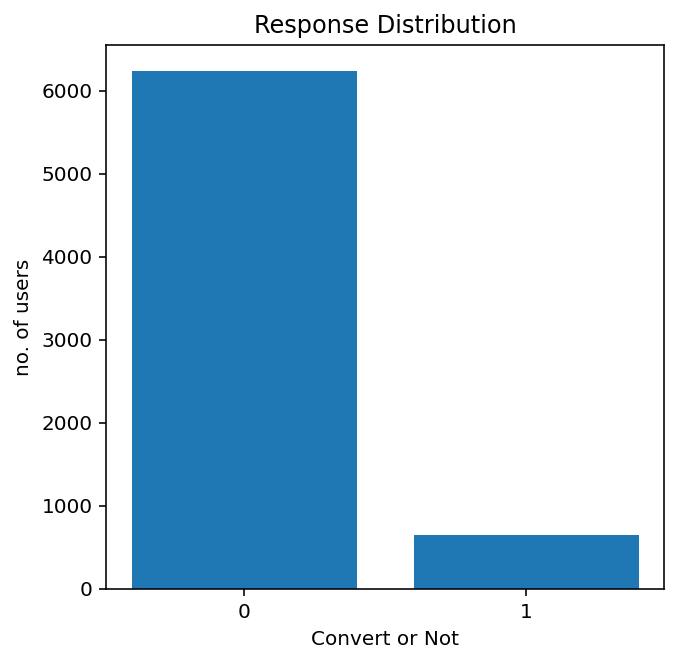

In [13]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [14]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [15]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


## **Creating train and test dataset**

In [16]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [17]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

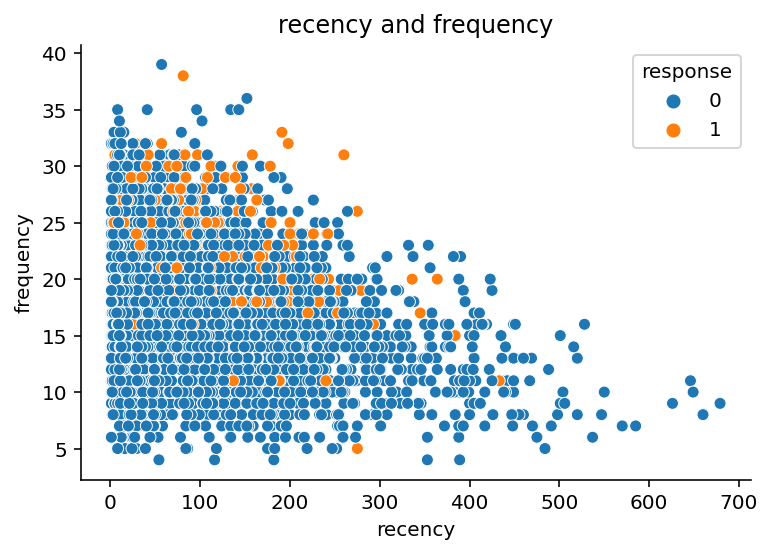

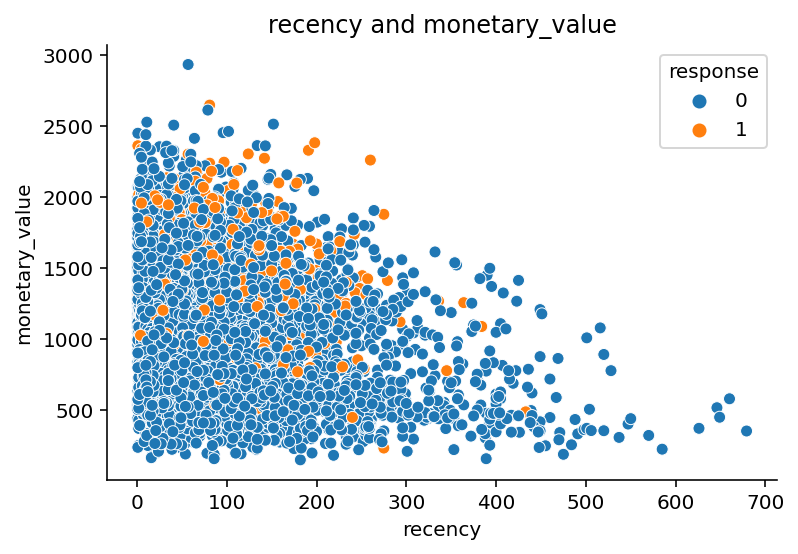

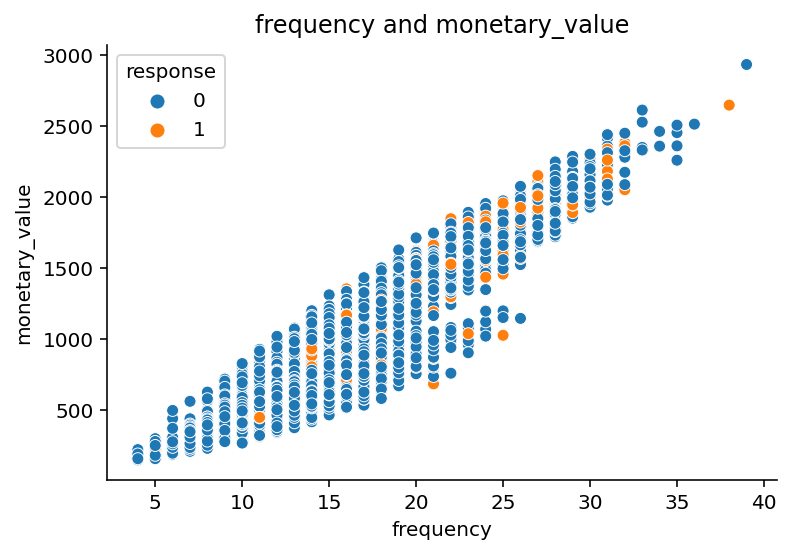

In [18]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

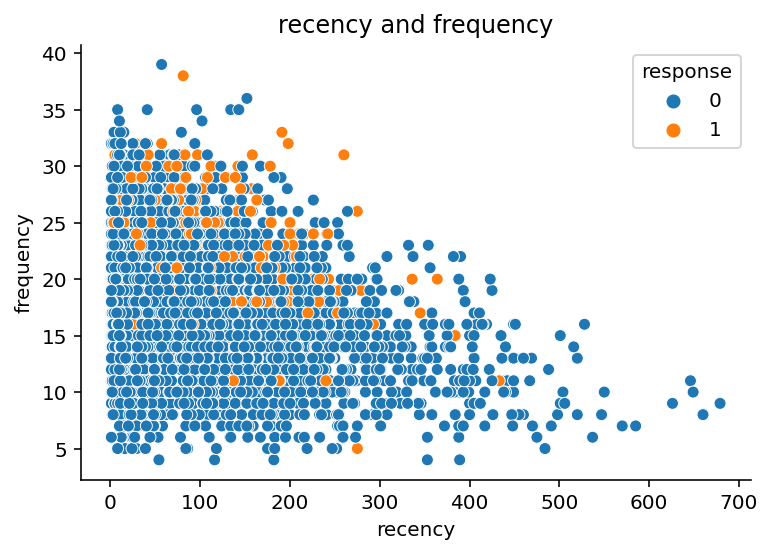

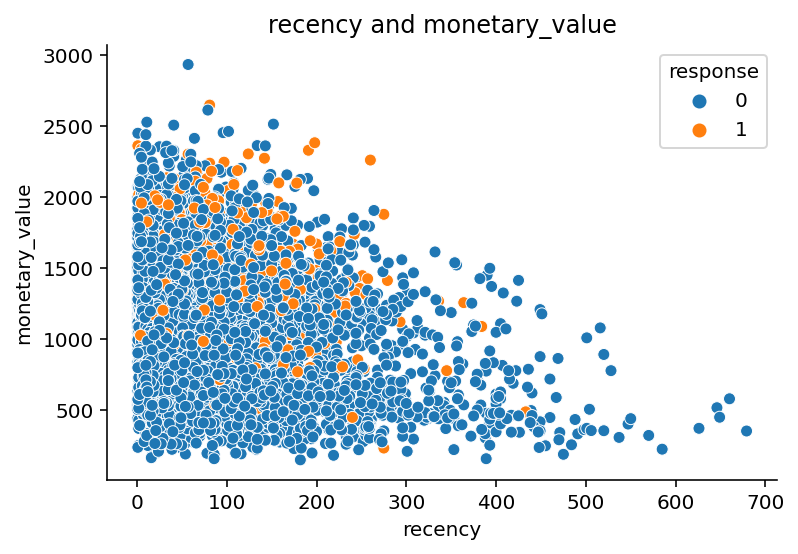

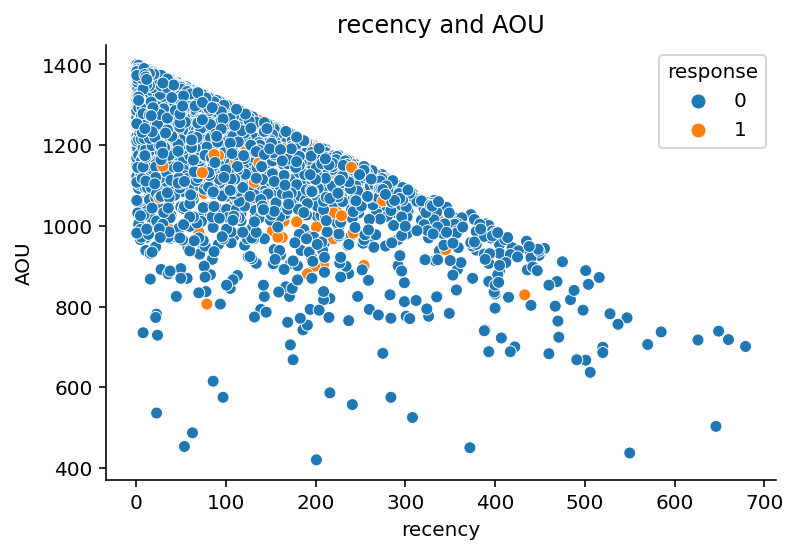

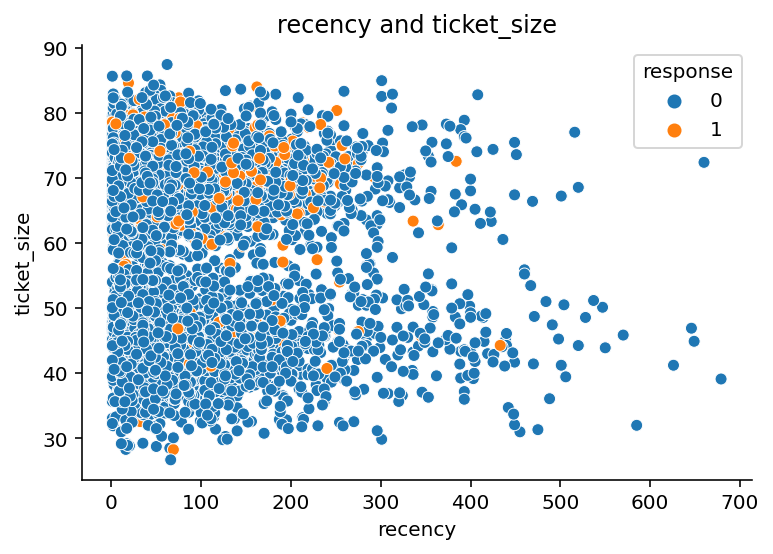

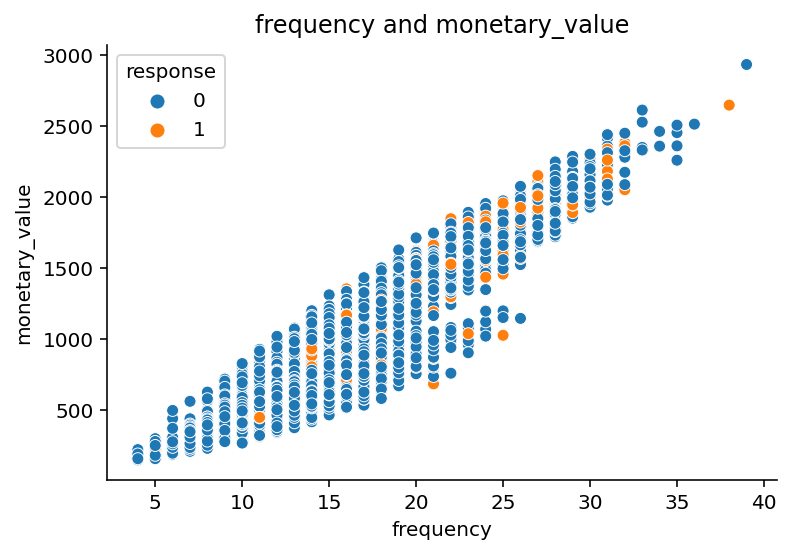

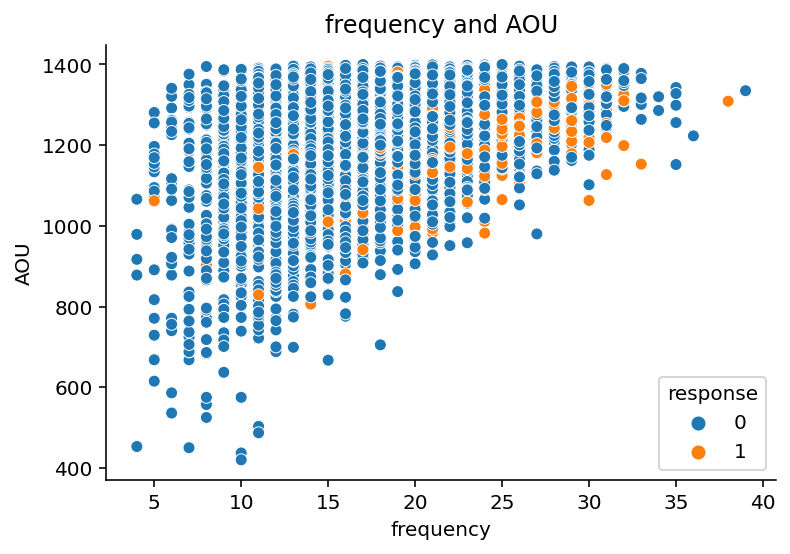

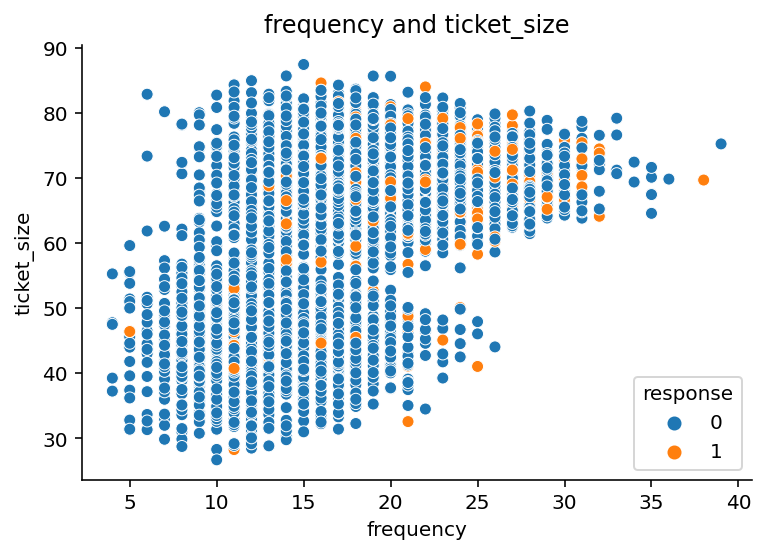

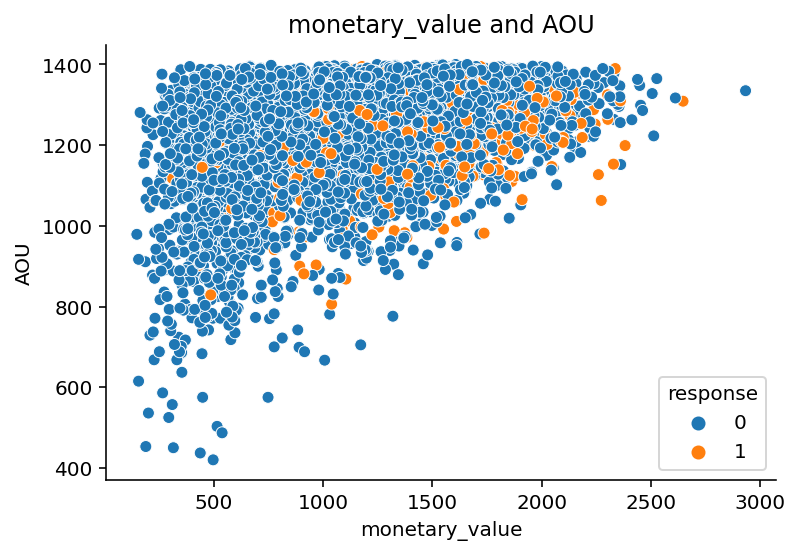

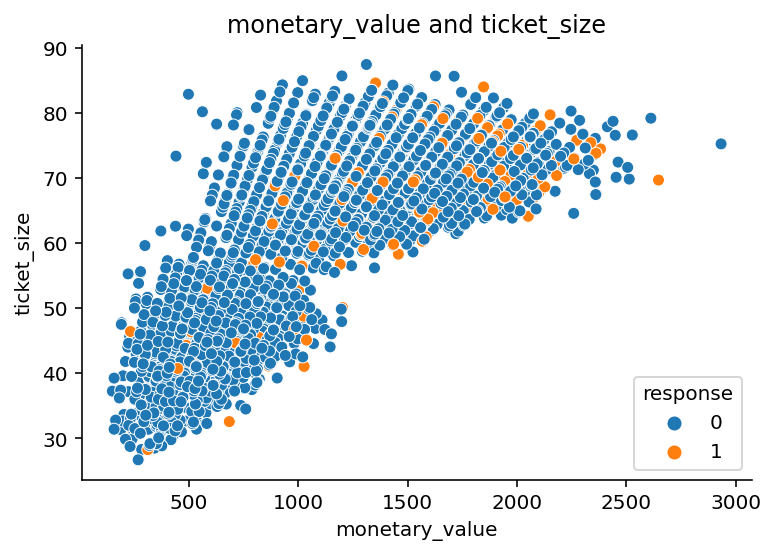

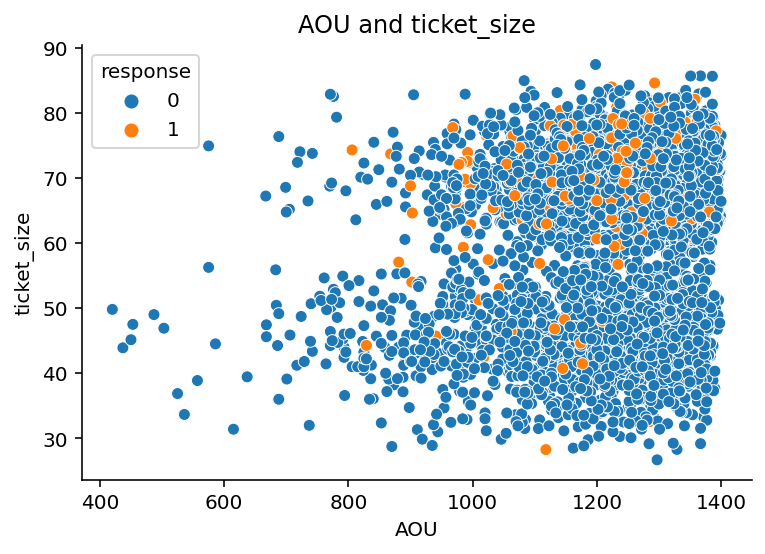

In [19]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [20]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [21]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      4389
           1       0.64      0.73      0.69      4389

    accuracy                           0.66      8778
   macro avg       0.67      0.66      0.66      8778
weighted avg       0.67      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      1848
           1       0.18      0.72      0.28       218

    accuracy                           0.61      2066
   macro avg       0.56      0.66      0.51      2066
weighted avg       0.87      0.61      0.69      2066



In [22]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      4389
           1       0.67      0.71      0.69      4389

    accuracy                           0.68      8778
   macro avg       0.68      0.68      0.68      8778
weighted avg       0.68      0.68      0.68      8778

test set
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      1848
           1       0.18      0.65      0.28       218

    accuracy                           0.65      2066
   macro avg       0.56      0.65      0.53      2066
weighted avg       0.86      0.65      0.72      2066



## **XGBoost**

In [23]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

X_SMOTE_rfm.columns = ['f0', 'f1', 'f2']
xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.56761
[1]	validation_0-auc:0.70923
[2]	validation_0-auc:0.71790
[3]	validation_0-auc:0.71366
[4]	validation_0-auc:0.71767
[5]	validation_0-auc:0.71974
[6]	validation_0-auc:0.72055
[7]	validation_0-auc:0.71645
[8]	validation_0-auc:0.72031
[9]	validation_0-auc:0.71767
[10]	validation_0-auc:0.71657
[11]	validation_0-auc:0.71721
training set

D:\py\envs\7105\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



              precision    recall  f1-score   support

           0       0.72      0.60      0.65      4389
           1       0.66      0.77      0.71      4389

    accuracy                           0.68      8778
   macro avg       0.69      0.68      0.68      8778
weighted avg       0.69      0.68      0.68      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.60      0.73      1848
           1       0.18      0.77      0.30       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.52      2066
weighted avg       0.87      0.61      0.69      2066



In [24]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

X_SMOTE_clv.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.64327
[1]	validation_0-auc:0.69855
[2]	validation_0-auc:0.70206
[3]	validation_0-auc:0.70901
[4]	validation_0-auc:0.71353
[5]	validation_0-auc:0.71133
[6]	validation_0-auc:0.71181
[7]	validation_0-auc:0.71280
[8]	validation_0-auc:0.71692
[9]	validation_0-auc:0.72240
[10]	validation_0-auc:0.72235
[11]	validation_0-auc:0.72164
[12]	validation_0-auc:0.72217
[13]	validation_0-auc:0.72190
[14]	validation_0-auc:0.72293
[15]	validation_0-auc:0.72277
[16]	validation_0-auc:0.72219
[17]	validation_0-auc:0.72286
[18]	validation_0-auc:0.72313
[19]	validation_0-auc:0.72259


D:\py\envs\7105\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20]	validation_0-auc:0.72308
[21]	validation_0-auc:0.72259
[22]	validation_0-auc:0.72264
training set
              precision    recall  f1-score   support

           0       0.74      0.58      0.65      4389
           1       0.66      0.80      0.72      4389

    accuracy                           0.69      8778
   macro avg       0.70      0.69      0.69      8778
weighted avg       0.70      0.69      0.69      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1848
           1       0.18      0.79      0.30       218

    accuracy                           0.60      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.88      0.60      0.68      2066



In [25]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [26]:
%%time
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
# search_space = [
#   {
#     'clf__n_estimators': [100, 300],
#     'clf__learning_rate': [0.01, 0.1],
#     'clf__max_depth': range(2, 5),
#     'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
#     'clf__gamma': [i/10.0 for i in range(3)],
#     'fs__score_func': [chi2],
#     'fs__k': [2],
#   }
# ]
search_space = [
  {
    'clf__n_estimators': [50, 500],
    'clf__learning_rate': [0.005, 0.05],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(3, 6)],
    'clf__gamma': [i/100.0 for i in range(10)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
#kfold = KFold(n_splits=5, random_state=42)
#kfold = KFold(n_splits=5)
kfold = KFold(n_splits=7)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score), 'F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 7 folds for each of 360 candidates, totalling 2520 fits
[22:51:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8min 53s


D:\py\envs\7105\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [27]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_clv, predictions)))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7095680219577949
Accuracy: 0.6084220716360116
[[1091  757]
 [  52  166]]
test set
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      1848
           1       0.18      0.76      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066



In [28]:
#print(xgb_model_SMOTE_clv_GS.best_params_)
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.3, 'clf__gamma': 0.0, 'clf__learning_rate': 0.005, 'clf__max_depth': 2, 'clf__n_estimators': 50, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x0000021CD35DB280>}


Tuning K-Fold = 10
```
Best AUC Score: 0.7099437298314715
Accuracy: 0.6084220716360116
[[1091  757]
 [  52  166]]
test set
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      1848
           1       0.18      0.76      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x000001A99D64D550>}
```


In [30]:
Tuning K-Fold = 7

```
Best AUC Score: 0.711163386965921
Accuracy: 0.6084220716360116
[[1091  757]
 [  52  166]]
test set
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      1848
           1       0.18      0.76      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x000001A99D64D550>}
```

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

Tuning K-Fold = 5

```
Best AUC Score: 0.7090578907592887
Accuracy: 0.6084220716360116
[[1091  757]
 [  52  166]]
test set
              precision    recall  f1-score   support

           0       0.95      0.59      0.73      1848
           1       0.18      0.76      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x000001A99D64D550>}
```

Tuning K-Fold = 3
```
Best AUC Score: 0.7057042083132293
Accuracy: 0.6079380445304937
[[1089  759]
 [  51  167]]
test set
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1848
           1       0.18      0.77      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x000001A99D64D550>}
```

Original K-Fold = 5
```
Best AUC Score: 0.7089054675375633
Accuracy: 0.6079380445304937
[[1089  759]
 [  51  167]]
test set
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1848
           1       0.18      0.77      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066

{'clf__colsample_bytree': 0.6, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f0a8b253a60>}
```